In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [31]:
recs = pd.read_csv('cleaned_recs.csv')[['Document File Name ', 'Recommendation text']].dropna(0, 'all')
# df = df[['Recommendation text']].dropna().reset_index(drop = True)
file_mapping = pd.read_csv("file_mapping.csv")

In [35]:
merged = pd.merge(recs, file_mapping, left_on="Document File Name ", right_on="original_name", how='inner')

In [50]:
merged.columns

Index(['Document File Name ', 'Recommendation text', 'original_name',
       'indexed_name'],
      dtype='object')

In [57]:
test = merged.loc[(merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf')]
train = merged.loc[~((merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf'))]

In [58]:
train.shape[0], test.shape[0]

(100, 9)

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
stopwords = nltk.corpus.stopwords.words('english')

def plot_top_ngrams_barchart(text, n):
    stop=set(stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

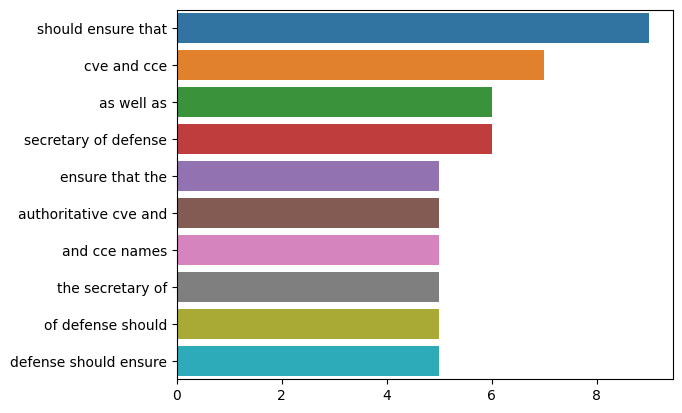

In [49]:
plot_top_ngrams_barchart(merged['Recommendation text'], n=3)

In [41]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensim
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

def get_lda_objects(text):   
    stop=set(nltk.corpus.stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [42]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/shubham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shubham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/shubham/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
lda_model, bow_corpus, dic = get_lda_objects(merged['Recommendation text'])

In [45]:
lda_model.show_topics()

[(0,
  '0.023*"name" + 0.021*"CVE" + 0.018*"vulnerability" + 0.015*"CCE" + 0.014*"product" + 0.010*"system" + 0.010*"service" + 0.009*"security" + 0.009*"vendor" + 0.009*"CPE"'),
 (1,
  '0.008*"information" + 0.007*"use" + 0.007*"sector" + 0.007*"cybersecurity" + 0.007*"agency" + 0.007*"technology" + 0.007*"command" + 0.007*"foreign" + 0.005*"government" + 0.005*"process"'),
 (2,
  '0.015*"The" + 0.012*"DOD" + 0.010*"cyber" + 0.009*"ensure" + 0.009*"Defense" + 0.009*"Secretary" + 0.009*"plan" + 0.008*"sector" + 0.006*"component" + 0.006*"CIO"'),
 (3,
  '0.014*"input" + 0.009*"must" + 0.009*"validated" + 0.007*"used" + 0.007*"state" + 0.007*"All" + 0.007*"business" + 0.007*"The" + 0.007*"sector" + 0.006*"also"')]

In [46]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.148742 -0.007418       1        1  31.752125
2     -0.042284  0.114858       2        1  26.202945
1     -0.049526 -0.021179       3        1  22.788421
3     -0.056932 -0.086262       4        1  19.256508, topic_info=           Term       Freq      Total Category  logprob  loglift
8          name  13.000000  13.000000  Default  30.0000  30.0000
1           CVE  12.000000  12.000000  Default  29.0000  29.0000
0           CCE   9.000000   9.000000  Default  28.0000  28.0000
11      product   8.000000   8.000000  Default  27.0000  27.0000
89        input   6.000000   6.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
373   oversight   1.357403   4.497750   Topic4  -5.5354   0.4493
513    critical   1.357307   3.947475   Topic4  -5.5355   0.5797
382    specific   1.357019   3.919517   Topic4  -5.5357   0.5866
553  capability   1.356419   4.470530   Topic4  -5.5361   0.4547
88         data   1.356277   3.150013   Topic4  -5.5362   0.8047

[246 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
86        2  0.267087        All
86        4  0.801262        All
584       3  0.768775  Answering
684       2  0.994956  Awareness
0         1  0.988113        CCE
...     ...       ...        ...
47        1  0.621428       well
47        2  0.414286       well
125       4  0.536980  whitelist
287       2  0.381499       work
287       3  0.381499       work

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [18]:
# WHO NEEDS WORDCLOUDS ANYWAY

# from wordcloud import WordCloud

# def plot_wordcloud(text):
#     stop=set(nltk.corpus.stopwords.words('english'))

#     def _preprocess_text(text):
#         corpus=''
#         stem=PorterStemmer()
#         lem=WordNetLemmatizer()
#         for news in text:
#             words=[w for w in word_tokenize(news) if (w not in stop)]

#             words=[lem.lemmatize(w) for w in words if len(w)>2]

#             corpus += ' '.join(words)
#         return corpus
    
#     corpus=_preprocess_text(text)
    
#     wordcloud = WordCloud(
#         background_color='salmon', colormap='Pastel1',
#         stopwords=stop,
#         max_words=100,
#         max_font_size=30, 
#         scale=3,
#         random_state=1)
    
#     wordcloud=wordcloud.generate(corpus)

#     fig = plt.figure(1, figsize=(20, 15))
#     plt.axis('off')
 
#     plt.imshow(wordcloud)
#     plt.show()

# plot_wordcloud(df['Recommendation text'])

## Sentence embeddings

In [47]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [59]:
sentences = train['Recommendation text'].to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [60]:
sentence_embeddings.shape

(100, 768)

In [61]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

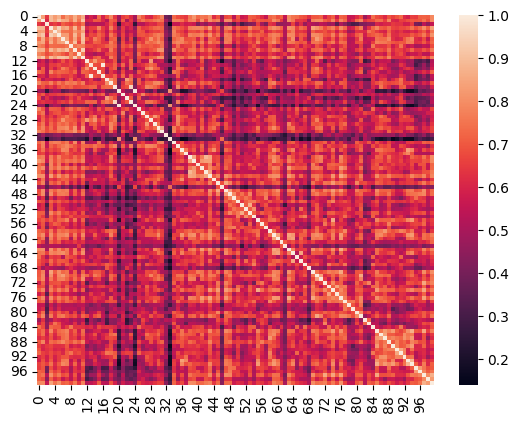

In [62]:
ax = sns.heatmap(matrix)

In [63]:
recomm = np.mean(sentence_embeddings,axis=0)

In [65]:
from tika import parser

raw12 = parser.from_file('12.pdf')
raw9 = parser.from_file('9.pdf')

2023-04-20 20:15:22,522 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2023-04-20 20:15:25,693 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2023-04-20 20:15:26,156 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
text12 = raw12['content'].replace('\n','')
text9 = raw9['content'].replace('\n','')

text = text12 + ' ' + text9

In [73]:
sentences = nltk.sent_tokenize(text)

In [74]:
relevant = []
distances = []

for sentence in sentences:
  embedd = sbert_model.encode(sentence)
  distances.append(cosine(recomm, embedd))

In [91]:
sorted_idx = sorted(range(len(distances)), key=lambda k: distances[k], reverse=True)
sorted_sentences = np.array(sentences)[sorted_idx]

In [99]:
sorted_distances = sorted(distances, reverse=True)

preds = pd.DataFrame(list(zip(sorted_sentences, sorted_distances)), columns=['Sentence', 'Cosine'])

In [137]:
import difflib

def retrieve_sentence_index(sentence, sentence_list):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    sentence_list_tokens = [s.split() for s in sentence_list]
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    # Check if the retrieved sentence contains the original sentence
    # retrieved_sentence = sentence_list[max_similarity_index]
    # if sentence in retrieved_sentence:
    #     return max_similarity_index
    # else:
    #     return None
    return max_similarity_index

In [143]:
test_preds = preds.iloc[[retrieve_sentence_index(sentence, preds['Sentence']) for sentence in test.iloc[:, 1]], :]
final = test_preds.set_index(100 * test_preds.index/len(preds)).sort_index()

In [144]:
final

,Sentence,Cosine
0.529101,Agencies should identify the CVE entries that ...,0.881533
1.058201,Domestic and foreign policy oversight by compe...,0.862859
2.248677,Federal departments and agencies should period...,0.830548
2.777778,3http://cve.mitre.org/http://icat.nist.gov/htt...,0.826420
5.555556,"Intelligence oversight, including an “intellig...",0.791437
6.349206,Since it is infeasible for an organization to ...,0.784882
9.788360,Such oversight also should provide assess-ment...,0.757797
10.582011,Technical oversight that includes a “technical...,0.749276
23.677249,Operational oversight with appropriate respons...,0.689108
